# Computing Reduced Density Matrices from MPO

### Basics Imports

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    #level=logging.INFO
    level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
import numpy as np
import pandas as pd
import sys

### TensorNetworks imports

In [ ]:
sys.path.append("../")
import tensornetworks as tn
import tn_quantum_circuits as tnqc
import gates as gt
from tensornetworks import contract_indices, contract_indices_one_tensor

### Imports QLM

In [ ]:
import qat.lang.AQASM as qlm
from qat.qpus import PyLinalg
qpu_p = PyLinalg()
from qlm_stuff import proccess_qresults

## 1. Functions for creating the MPS

In [ ]:
def apply_2qubit_gates(qubits, gates):
    """
    Executes product of tensor with a gate
    -o-o-o-o-o-..o-o-
     |   |   |     |
    """
    new_qubits = [0 for i in qubits]
    left = qubits[0]
    for i in range(1, len(qubits)):
        right = qubits[i]
        gate = gates[i-1]
        #new_qubits[i-1], left = phase_change(left, right, gate)
        new_qubits[i-1], left = tnqc.apply_2qubit_gate(left, right, gate)

    new_qubits[-1], new_qubits[0] = tnqc.apply_2qubit_gate(
        left, new_qubits[0], gates[-1])
     #new_qubits[-1], new_qubits[0] = phase_change(left, new_qubits[0], gates[-1])
    return new_qubits

In [ ]:
def get_angles(depth):
    theta = np.pi/4.0
    delta_theta = theta / (depth + 1)
    angles = []
    for i in range(depth):
        angles.append([(2 * i + 1) * delta_theta, (2 * i + 2) * delta_theta])
    return angles     

In [ ]:
def ansatz(nqubits, depth, angles):
    # Intitial State
    zeroket = np.zeros((1, 2, 1))
    zeroket[0][0][0] = 1
    zeroket = zeroket.astype(complex)
    #Initial State
    mps_ = [zeroket] * nqubits
    for depth_ in range(depth):
        # First Layer
        gates = [gt.x_rotation(angles[depth_][0]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
        ent_gates = [gt.controlz() for i in mps_]
        mps_ = apply_2qubit_gates(mps_, ent_gates)
        gates = [gt.z_rotation(angles[depth_][1]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
    return mps_

In [ ]:
def ansatz_qlm(nqubits, depth, angles):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for d_ in range(0, depth):
        for i in range(nqubits):
            qprog.apply(qlm.RX(angles[d_][0]), qbits[i])
        for i in range(nqubits-1):
            qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
        qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
        for i in range(nqubits):
            qprog.apply(qlm.RZ(angles[d_][1]), qbits[i])    
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

## 2. Creating MPS

In [ ]:
# MPS uisng My code
depth = 1
nqubits = 4
mps = ansatz(nqubits, depth, get_angles(depth))

In [ ]:
# State of MPS
pdf_zalo = tnqc.get_state_from_mps(mps)

In [ ]:
#Stat of circuit for comparing with MPS computations
pdf, c= ansatz_qlm(nqubits, depth,  get_angles(depth))

In [ ]:
%qatdisplay c --svg

In [ ]:
# Testing if state from MPS is equat to state from QLM circuit
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

In [ ]:
[mps_.shape for mps_ in mps]

### Testing  Isometry

In [ ]:
# Identitidad: U.T @ U
tensor = mps[3]
iso = tn.contract_indices(tensor, tensor.conj(), [0, 1], [0, 1])
np.isclose(iso, np.eye(iso.shape[0])).all()

In [ ]:
#Proyector U @U.T
tensor = mps[3]
iso = tn.contract_indices(tensor, tensor.conj(), [2], [2])
projector = iso.reshape(np.product(iso.shape[:2]), np.product(iso.shape[:2]))
np.isclose(projector @ projector, projector).all()

In [ ]:
# Identitidad: U.T @ U
tensor = mps[0]
iso = tn.contract_indices(tensor, tensor.conj(), [1, 2], [1, 2])
np.isclose(iso, np.eye(iso.shape[0])).all()

## 2. Computing density matrix

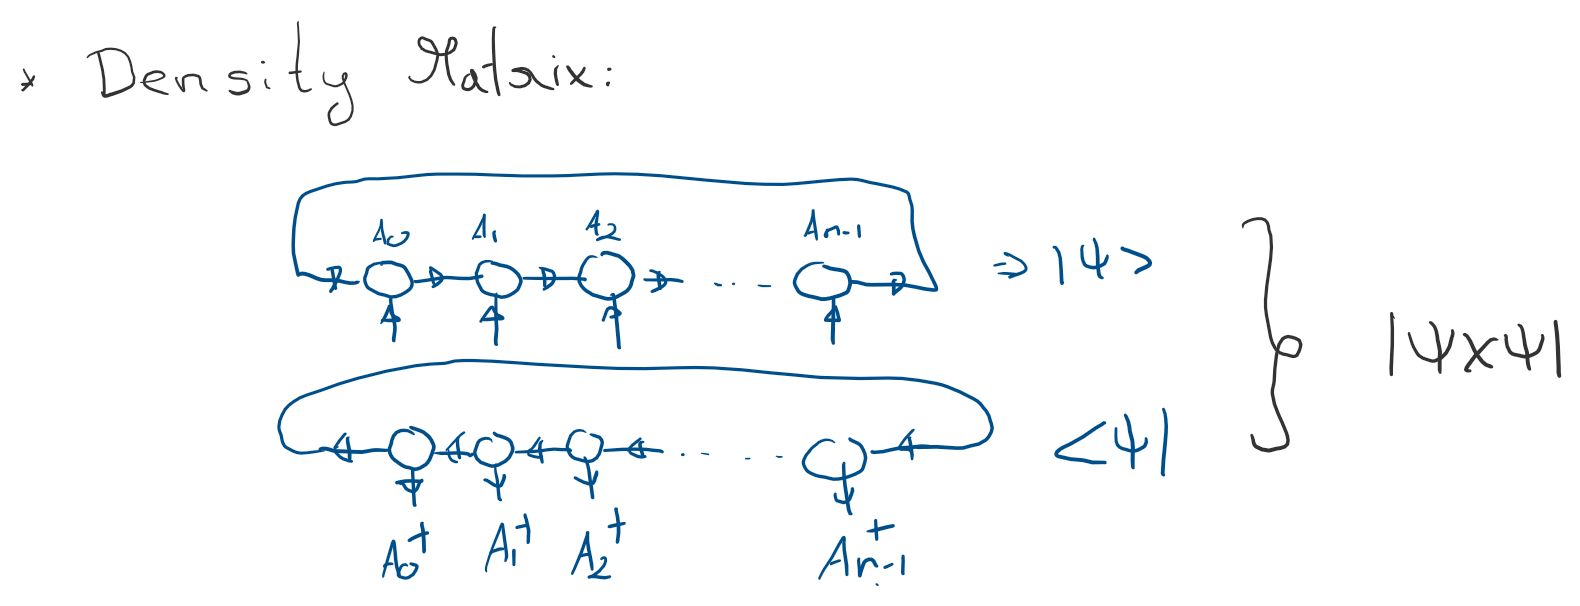

In [ ]:
[mps_.shape for mps_ in mps]

In [ ]:
# Naive Computation of density matrix: |Phi><Psi|
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(amp.shape[0], 1)
rho0 = amp @ amp.conj().T

In [ ]:
# Computing Density Matrix using reduced_matrix for pure tensors
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(tuple([2 for i in range(nqubits)]))
rho1 = tn.reduced_matrix(amp, [0, 1, 2, 3], [])

In [ ]:
#Testing both computations are equivalent
np.isclose(rho0, rho1).all()

## 3. Conputing Reduced Density Matrices from MPS

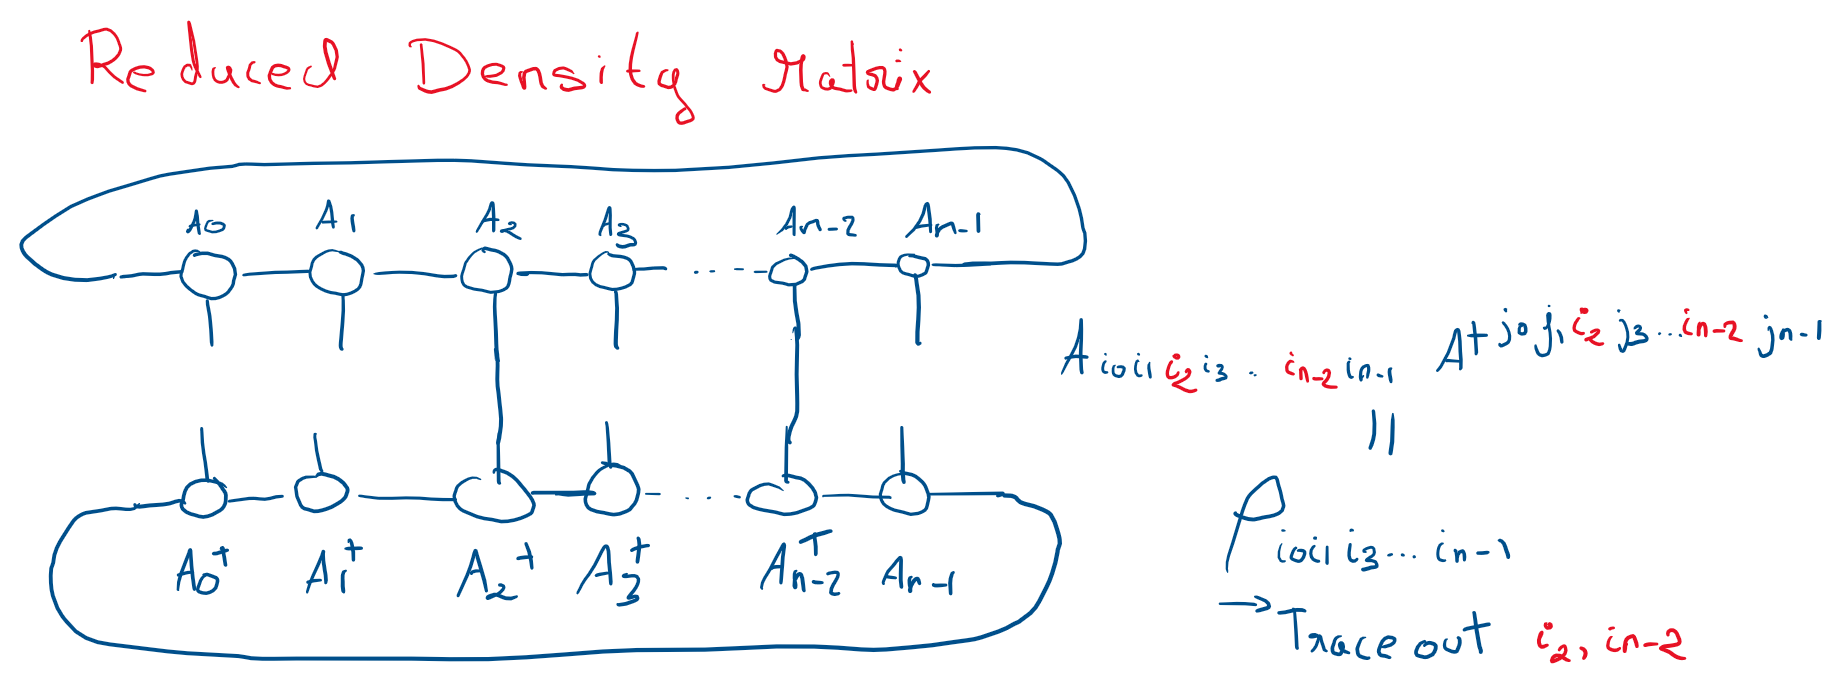


### 3.1 Site Operations

For each site we need to compute the corresponding operation. There are only two types of operation at each site:



Tensor of type 1 are rank-4 tensors meanwhile type 2 are rank-2 tensors:

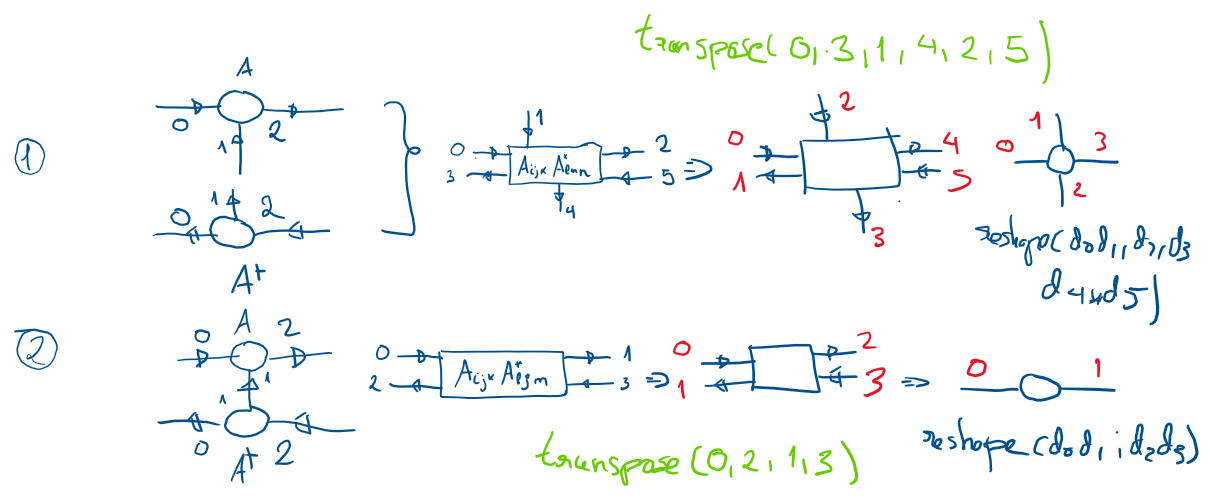


In [ ]:
tensor = mps[0]
tensor_1 = contract_indices(tensor, tensor.conj(), [], [])
tensor_1 = tensor_1.transpose(0, 3, 1, 4, 2, 5)
reshape = [
    tensor_1.shape[0] * tensor_1.shape[1], 
    tensor_1.shape[2], tensor_1.shape[3],
    tensor_1.shape[4] * tensor_1.shape[5], 
]
tensor_1 = tensor_1.reshape(reshape)

In [ ]:
tensor.shape, tensor_1.shape, tensor_1.ndim

In [ ]:
tensor = mps[1]
tensor_2 = contract_indices(tensor, tensor.conj(), [1], [1])
tensor_2 = tensor_2.transpose(0, 2, 1, 3)
reshape = [
    tensor_2.shape[0] * tensor_2.shape[1], 
    tensor_2.shape[2] * tensor_2.shape[3]
]
tensor_2 = tensor_2.reshape(reshape)

In [ ]:
tensor.shape, tensor_2.shape, tensor_2.ndim

### 3.2 Operation on 2 consecutive sites

Now we need a function that takes two consecutive site tensors and transform them into one tensor. Main idea is that the output tensor can be used in a recursive way with this function for computing the whole operation 8this is compute the complete reduced density matrix). This function is **density_matrix_mps_contracion**. 

The 2 psoible inputs can be only the 2 before tensor sites (see section 3.2). And there are four posible combinations:


In [ ]:
from tensornetworks import mpo_contraction

#### Rank-4, Rank-4

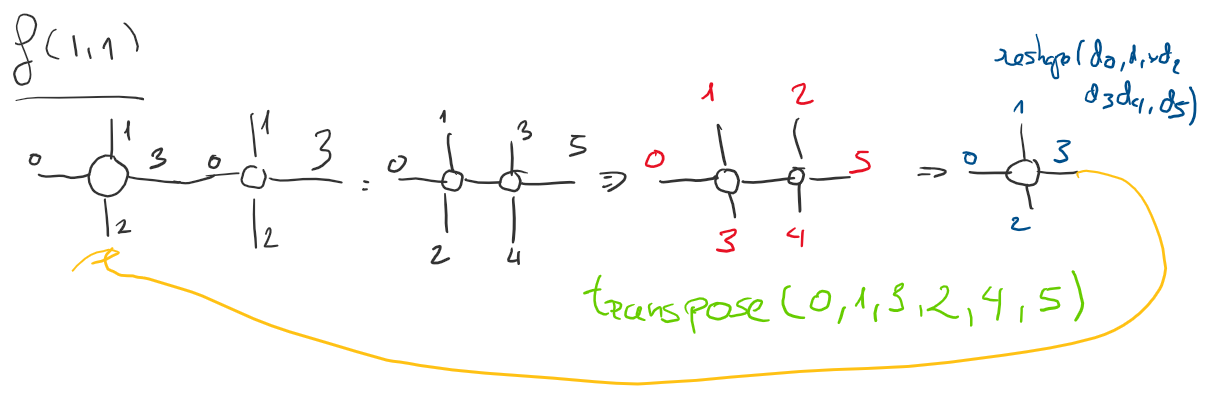


In [ ]:
tensor_1_like = tensor_1
tensor_2_like = tensor_1.transpose(3, 1, 2, 0)

tensor_out = mpo_contraction(tensor_1_like, tensor_2_like)

In [ ]:
tensor_1_like.shape, tensor_2_like.shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_1_like.shape[0],
    tensor_out.shape[1] == tensor_1_like.shape[1] *  tensor_2_like.shape[1],
    tensor_out.shape[2] == tensor_1_like.shape[2] *  tensor_2_like.shape[2],
    tensor_out.shape[3] == tensor_2_like.shape[3],
])

#### Rank-4, Rank-2

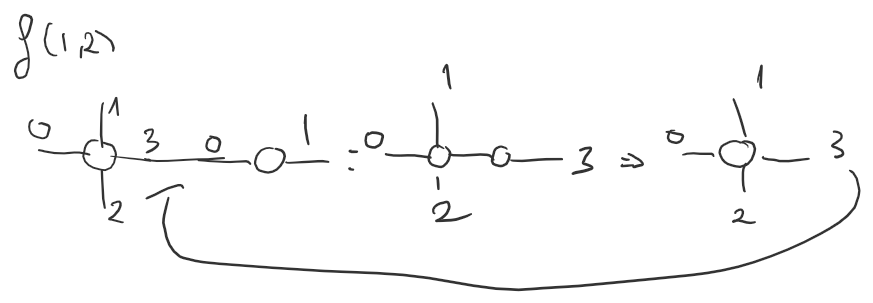



In [ ]:
tensor_case2_1 = tensor_1
tensor_case2_2 = tensor_2
tensor_out = mpo_contraction(tensor_case2_1, tensor_case2_2)

In [ ]:
tensor_case2_1.shape, tensor_case2_2.shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_case2_1.shape[0],
    tensor_out.shape[1] == tensor_case2_1.shape[1],
    tensor_out.shape[2] == tensor_case2_1.shape[2],
    tensor_out.shape[3] == tensor_case2_2.shape[1]
])

#### Rank-2, Rank-4


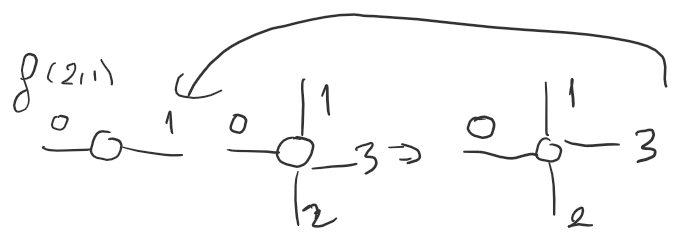


In [ ]:
tensor_2.shape

In [ ]:
tensor_1.shape

In [ ]:
tensor_case3_1 = tensor_2
tensor_case3_2 = tensor_1.transpose(3, 1, 2, 0)
tensor_out = mpo_contraction(tensor_case3_1, tensor_case3_2)

In [ ]:
tensor_case3_1.shape, tensor_case3_2.shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_case3_1.shape[0],
    tensor_out.shape[1] == tensor_case3_2.shape[1],
    tensor_out.shape[2] == tensor_case3_2.shape[2],
    tensor_out.shape[3] == tensor_case3_2.shape[3],
])

#### Rank-2, Rank-2


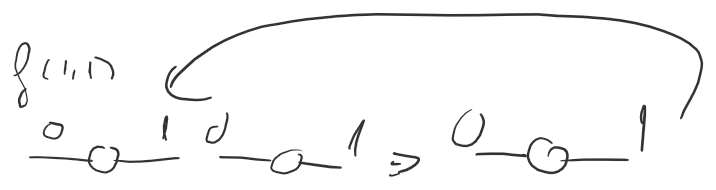

In [ ]:
tensor_case4_1 = tensor_2
tensor_case4_2 = tensor_2.transpose(1, 0)
tensor_out = mpo_contraction(tensor_case4_1, tensor_case4_2)

In [ ]:
tensor_case4_1.shape, tensor_case4_2.shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_case4_1.shape[0],
    tensor_out.shape[1] == tensor_case4_2.shape[1]
])

In [ ]:
from tensornetworks import mpo_contraction
def reduced_rho_mps(mps, free_indices, contraction_indices):
    i = 0
    tensor_out = mps[i]
    # Starting Tensor for Denisty Matrix
    
    tensor = mps[0]

    
    if i in free_indices:
        
        tensor_out = contract_indices(tensor_out, tensor_out.conj(), [], [])
        tensor_out = tensor_out.transpose(0, 3, 1, 4, 2, 5)
        reshape = [
            tensor_out.shape[0] * tensor_out.shape[1], 
            tensor_out.shape[2], tensor_out.shape[3],
            tensor_out.shape[4] * tensor_out.shape[5], 
        ]
        tensor_out = tensor_out.reshape(reshape)

    elif i in contraction_indices:
        
        tensor_out = contract_indices(tensor_out, tensor_out.conj(), [1], [1])
        tensor_out = tensor_out.transpose(0, 2, 1, 3)
        reshape = [
            tensor_out.shape[0] * tensor_out.shape[1], 
            tensor_out.shape[2] * tensor_out.shape[3]
        ]
        tensor_out = tensor_out.reshape(reshape)        
        
    else:
        raise ValueError("Problem with site i: {}".format(i))
    
    for i in range(1, len(mps)):
        tensor = mps[i]
        if i in free_indices:
            tensor = contract_indices(tensor, tensor.conj(), [], [])
            tensor = tensor.transpose(0, 3, 1, 4, 2, 5)
            reshape = [
                tensor.shape[0] * tensor.shape[1], 
                tensor.shape[2], tensor.shape[3],
                tensor.shape[4] * tensor.shape[5], 
            ]
            tensor = tensor.reshape(reshape)

        elif i in contraction_indices:
            tensor = contract_indices(tensor, tensor.conj(), [1], [1])
            tensor = tensor.transpose(0, 2, 1, 3)
            reshape = [
                tensor.shape[0] * tensor.shape[1], 
                tensor.shape[2] * tensor.shape[3]
            ]
            tensor = tensor.reshape(reshape)    
            
        else:
            raise ValueError("Problem with site i: {}".format(i))        
        
        tensor_out = mpo_contraction(tensor_out, tensor)
        
    tensor_out= contract_indices_one_tensor(tensor_out, [(0, 3)])
    
    return tensor_out   
    

In [ ]:
free = [0]
contraction = [1, 2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 1]
contraction = [2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 1, 2]
contraction = [3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 2]
contraction = [1, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 3]
contraction = [1, 2]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

### Mas Pruebas

In [ ]:
def contraction_pl(tensor):
    tensor = contract_indices(tensor, tensor.conj(), [1], [1])
    tensor = tensor.transpose(0, 2, 1, 3)
    reshape = [
        tensor.shape[0] * tensor.shape[1], 
        tensor.shape[2] * tensor.shape[3]
    ]
    tensor = tensor.reshape(reshape)
    return tensor

def reduced_rho_mpo_z(mps, free_indices, contraction_indices):
    opa = list(product([0, 1], repeat=2 * len(free_indices)))
    
    reduced_rho = np.zeros(
        (2**len(free_indices), 2**len(free_indices)), dtype="complex")
    
    l = []
    for step in opa:
        tensor_out = mps[0]
        if 0 in free_indices:
            i = free.index(0)
            tensor_out = np.kron(tensor_out[:, step[2*i], :], tensor_out.conj()[:, step[2*i+1], :])
        else:

            tensor_out = contraction_pl(tensor_out)
        for i in range(1, len(mps)):
            tensor = mps[i]
            if i in free_indices:
                j = free.index(i)
                tensor = np.kron(tensor[:, step[2*j], :], tensor.conj()[:, step[2*j+1], :])
            elif i in contraction_indices:
                tensor = contraction_pl(tensor)
            tensor_out = tensor_out @ tensor
        row = [v for i, v in enumerate(step) if i%2==0]
        row_int = sum([v * 2 ** i for i, v in enumerate(row)])
        #print(row, row_int)
        column = [v for i, v in enumerate(step) if i%2!=0]
        column_int = sum([v * 2 ** i for i, v in enumerate(column)])
        #print(column, column_int)
        reduced_rho[row_int, column_int] = np.trace(tensor_out)
    return reduced_rho
            

## AQUI

In [ ]:
# MPS uisng My code
depth = 3
nqubits = 10

In [ ]:
free = [0, 1, 2, 3, 4]
contraction = list(range(nqubits))
contraction = [i for i in contraction if i not in free]

In [ ]:
%%time
mps = ansatz(nqubits, depth, get_angles(depth))
#rho_mps = reduced_rho_mps(mps, free, contraction)
#rho_mps_z = reduced_rho_mpo_z(mps, free, contraction)

In [ ]:
%%time
#Stat of circuit for comparing with MPS computations
pdf, c= ansatz_qlm(nqubits, depth,  get_angles(depth))
# Computing Density Matrix using reduced_matrix for pure tensors
amp = np.array(pdf["Amplitude"])
amp = amp.reshape(tuple([2 for i in range(nqubits)]))
rho_qlm = tn.reduced_matrix(amp, free, contraction)

In [ ]:
from tensornetworks import mpo_contraction
def contraction_pl(tensor):
    tensor = contract_indices(tensor, tensor.conj(), [1], [1])
    tensor = tensor.transpose(0, 2, 1, 3)
    reshape = [
        tensor.shape[0] * tensor.shape[1], 
        tensor.shape[2] * tensor.shape[3]
    ]
    tensor = tensor.reshape(reshape)
    return tensor


In [ ]:
def reduced_rho_mpo_zalo(mps, free_indices, contraction_indices):
    # First deal with contraction indices
    tensor_contracted = contraction_pl(mps[contraction_indices[0]])
    print(tensor_contracted.shape)
    for i in contraction_indices[1:]:
        #print(i)
        tensor = contraction_pl(mps[i])
        tensor_contracted = mpo_contraction(tensor_contracted, tensor)    
    # Second deal with free indices
    tensor_free = mps[free_indices[0]]
    print(tensor_free.shape)
    for i in free_indices[1:]:
        #print(i)
        tensor = mps[i]
        #print(tensor.shape)
        tensor_free= contract_indices(tensor_free, tensor, [2], [0])
        #print(tensor_free.shape)
        reshape = [
            tensor_free.shape[0] , 
            tensor_free.shape[1] * tensor_free.shape[2],
            tensor_free.shape[3], 
        ]
        tensor_free = tensor_free.reshape(reshape)  
    
    tensor_free = contract_indices(tensor_free, tensor_free.conj(), [], [])
    tensor_free = tensor_free.transpose(0, 3, 1, 4, 2, 5)
    reshape = [
        tensor_free.shape[0] * tensor_free.shape[1],
        tensor_free.shape[2],  tensor_free.shape[3],
        tensor_free.shape[4] * tensor_free.shape[5]
    ]
    tensor_free = tensor_free.reshape(reshape)
    print(tensor_free.shape, tensor_contracted.shape)
    tensor_out = contract_indices(tensor_free, tensor_contracted, [3, 0], [0, 1])
    return tensor_out

In [ ]:
tensor_out = reduced_rho_mpo_zalo(mps, free, contraction)

In [ ]:
rho_qlm.shape

In [ ]:
tensor_out

In [ ]:
rho_qlm

In [ ]:
np.isclose(tensor_out, rho_qlm).all()

In [ ]:
np.isclose(rho_mps_z, rho_qlm).all()

In [ ]:
np.isclose(rho_mps_z, rho_mps).all()

In [ ]:
contraction

In [ ]:
tensor_contracted = contraction_pl(mps[contraction[0]])
print(tensor_contracted.shape)
for i in contraction[1:]:
    print(i)
    tensor = contraction_pl(mps[i])
    tensor_contracted = mpo_contraction(tensor_contracted, tensor)

In [ ]:
tensor_free = mps[free[0]]
print(tensor_free.shape)
for i in free[1:]:
    #print(i)
    tensor = mps[i]
    #print(tensor.shape)
    tensor_free= contract_indices(tensor_free, tensor, [2], [0])
    #print(tensor_free.shape)
    reshape = [
        tensor_free.shape[0] , 
        tensor_free.shape[1] * tensor_free.shape[2],
        tensor_free.shape[3], 
    ]
    tensor_free = tensor_free.reshape(reshape)
print(tensor_free.shape)

In [ ]:
print(tensor_free.shape, tensor_contracted.shape)

In [ ]:
tensor_free = contract_indices(tensor_free, tensor_free, [], [])

In [ ]:
tensor_free = tensor_free.transpose(0, 3, 1, 4, 2, 5)

In [ ]:
reshape = [
    tensor_free.shape[0] * tensor_free.shape[1],
    tensor_free.shape[2],  tensor_free.shape[3],
    tensor_free.shape[4] * tensor_free.shape[5]
]
tensor_free = tensor_free.reshape(reshape)

In [ ]:
tensor_free.shape

In [ ]:
opa = contract_indices(tensor_free, tensor_contracted, [0, 3], [1, 0])

In [ ]:
opa.shape

In [ ]:
[a.shape for a in mps]

In [ ]:
tensor_out.shape

In [ ]:
free

In [ ]:
for i in contraction:
    print(i)
    tensor = mps[i]
    tensor = contract_indices(tensor, tensor.conj(), [1], [1])
    tensor = tensor.transpose(0, 2, 1, 3)
    reshape = [
        tensor.shape[0] * tensor.shape[1], 
        tensor.shape[2] * tensor.shape[3]
    ]
    tensor = tensor.reshape(reshape)        

In [ ]:
    for i in range(1, len(mps)):
        tensor = mps[i]
        if i in free_indices:
            tensor = contract_indices(tensor, tensor.conj(), [], [])
            tensor = tensor.transpose(0, 3, 1, 4, 2, 5)
            reshape = [
                tensor.shape[0] * tensor.shape[1], 
                tensor.shape[2], tensor.shape[3],
                tensor.shape[4] * tensor.shape[5], 
            ]
            tensor = tensor.reshape(reshape)

        elif i in contraction_indices:
            tensor = contract_indices(tensor, tensor.conj(), [1], [1])
            tensor = tensor.transpose(0, 2, 1, 3)
            reshape = [
                tensor.shape[0] * tensor.shape[1], 
                tensor.shape[2] * tensor.shape[3]
            ]
            tensor = tensor.reshape(reshape)    
            
        else:
            raise ValueError("Problem with site i: {}".format(i))        
        
        tensor_out = mpo_contraction(tensor_out, tensor)
        
    tensor_out= contract_indices_one_tensor(tensor_out, [(0, 3)])
    
    return tensor_out   
    

In [ ]:
[a.shape for a in mps]

In [ ]:
from itertools import product

In [ ]:
list(product([0, 1], repeat=2 * len(free)))

In [ ]:
2**6

In [ ]:
kk = reduced_rho_mpo_z(mps,  free, contraction)

In [ ]:
free

In [ ]:
kk

In [ ]:
np.isclose(kk, rho_mps)

In [ ]:
a.dtype

In [ ]:
rho_mps

In [ ]:
kk

In [ ]:
step = opa[11]
print(step)

In [ ]:
row = [v for i, v in enumerate(step) if i%2==0]
row_int = sum([v * 2 ** i for i, v in enumerate(row)])
print(row, row_int)
column = np.array([v for i, v in enumerate(step) if i%2!=0])
column_int = sum([v * 2 ** i for i, v in enumerate(column)])
print(column, column_int)

In [ ]:
sum([v * 2 ** i for i, v in enumerate(row)])

In [ ]:
row

In [ ]:
row.astype(int)

In [ ]:
row

In [ ]:
2**3

In [ ]:
free

In [ ]:
contraction_pl(mps[0]).shape

In [ ]:
free.index(0)

In [ ]:
tensor_out = mps[0]

In [ ]:
tensor = contract_indices(tensor_out, tensor_out.conj(), [1], [1])
tensor = tensor.transpose(0, 2, 1, 3)

In [ ]:
tensor.shape

In [ ]:
tensor_out.shape

In [ ]:
tensor_out[:, 0, :]

In [ ]:
tensor_out.conj()[:, 0, :].shape

In [ ]:
a = contract_indices(tensor_out[:, 0, :], tensor_out.conj()[:, 0, :], [], []) 

In [ ]:
a.shape

In [ ]:
a = np.kron(tensor_out[:, 0, :], tensor_out.conj()[:, 0, :])

### 3.2 Computer pair contractions on a tensor.

As a last ingredient we need to compute in a tensor contraction ovr pair of indices. This is done using: **contract_indices_one_tensor**

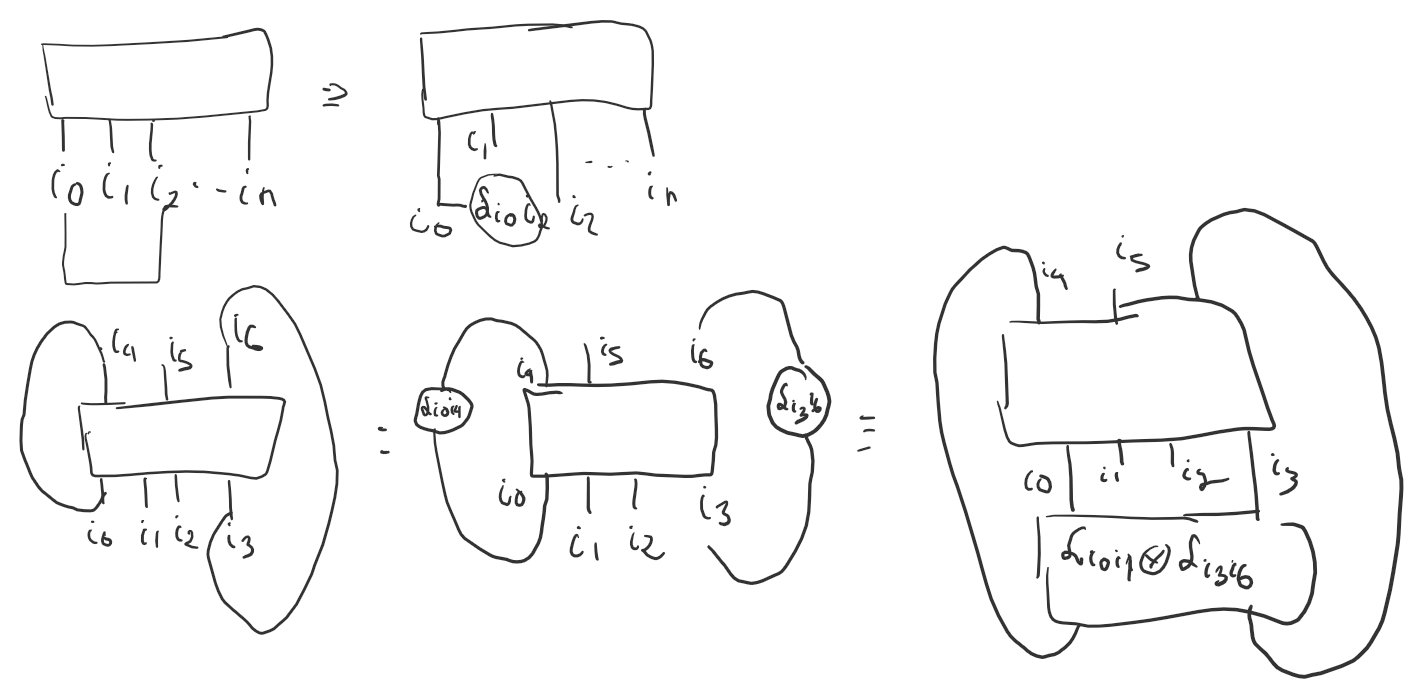

In [ ]:
tensor_1.shape

In [ ]:
np.isclose(
    np.einsum("AbcAde-> bcde", tensor_1),
    contract_indices_one_tensor(tensor_1, [(0, 3)])
).all()

In [ ]:
np.isclose(
    np.einsum("ABcABe-> ce", tensor_1),
    contract_indices_one_tensor(tensor_1, [(0, 3), (1, 4)])
).all()

In [ ]:
np.isclose(
    np.einsum("aAcdAe-> acde", tensor_1),
    contract_indices_one_tensor(tensor_1, [(1, 4)])
).all()

In [ ]:
np.isclose(
    np.einsum("aABdAB-> ad", tensor_1),
    contract_indices_one_tensor(tensor_1, [(1, 4), (2, 5)])
).all()

### 3.2 Computing using Zipper strategy

Finally we use the zipper strategy indicating which are the sites with no contraction (free) and with contraction

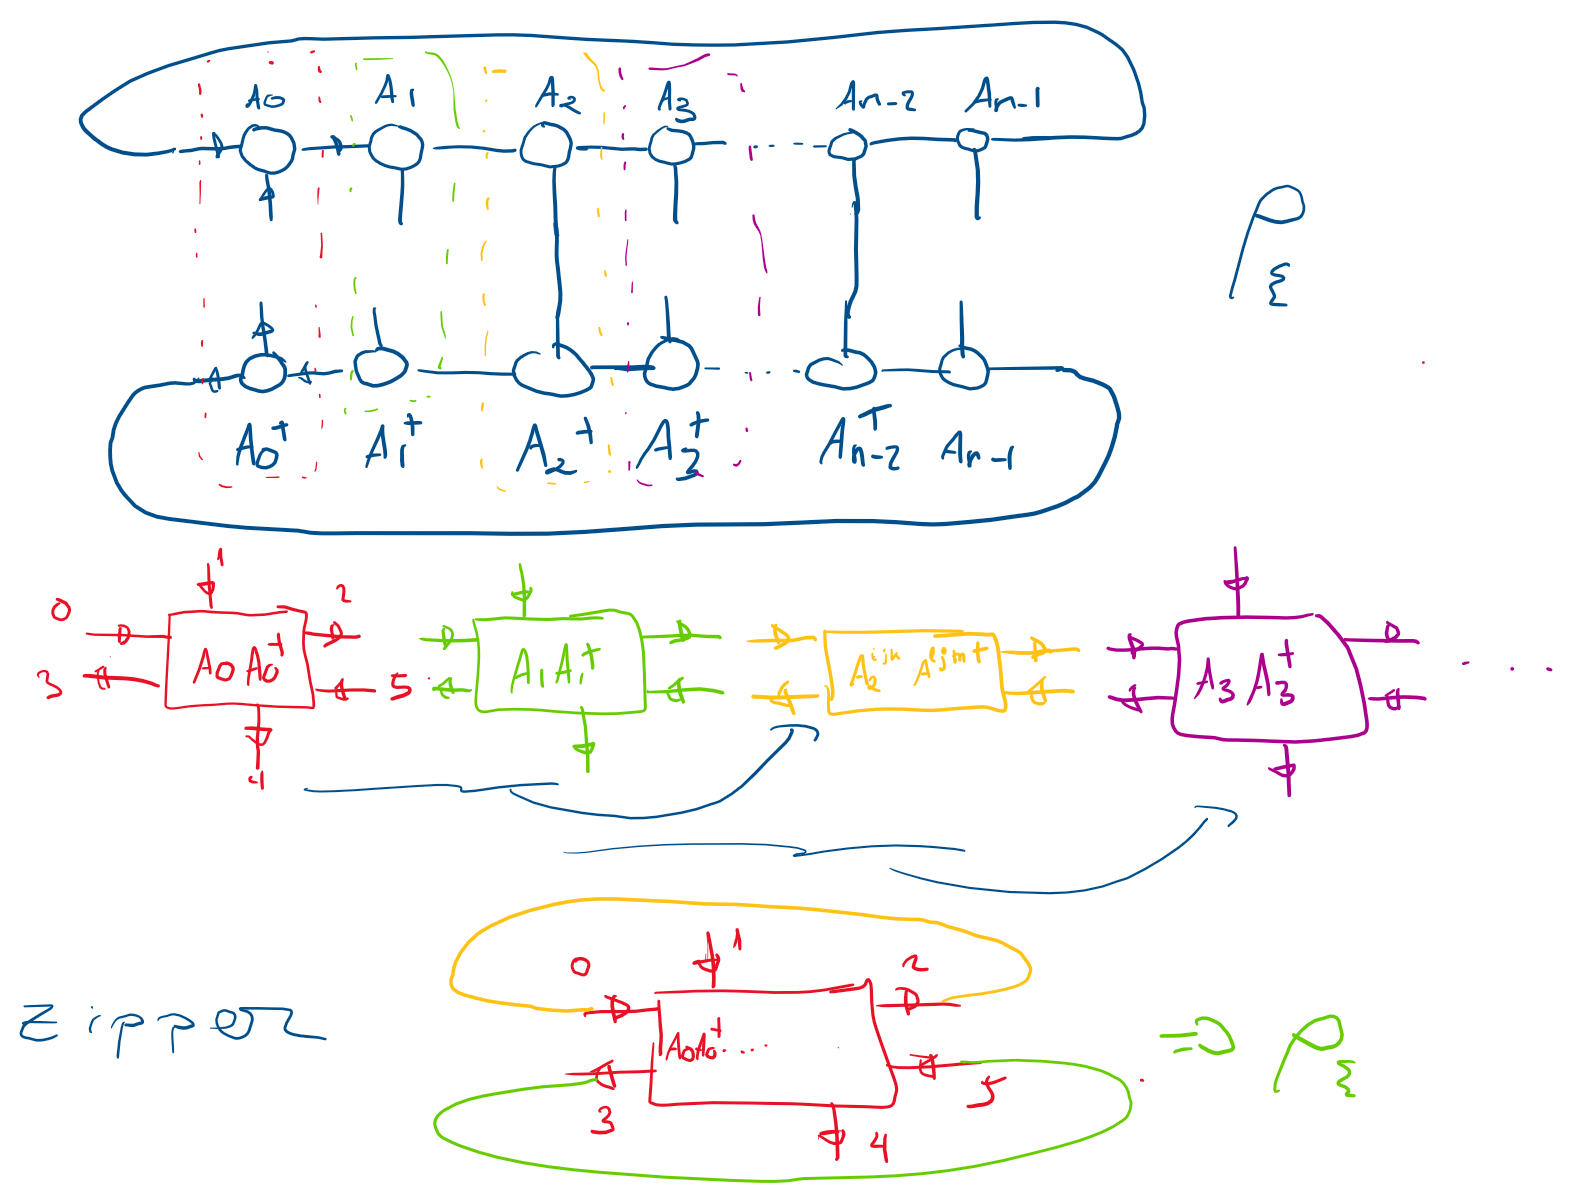

## Computing Norm of the MPS

In [ ]:
def compute_norm(mps):
    tensor_out = mps[0]
    tensor_out = contract_indices(tensor_out, tensor_out.conj(), [0, 1], [0, 1])
    for tensor in mps[1:-1]:
        tensor_out = contract_indices(tensor_out, tensor, [0], [0])
        tensor_out = contract_indices(tensor_out, tensor.conj(), [0, 1], [0, 1])
    tensor = mps[-1]
    tensor_out = contract_indices(tensor_out, tensor, [0], [0])
    tensor_out = contract_indices(tensor_out, tensor.conj(), [0, 1, 2], [0, 1, 2])  
    return tensor_out

In [ ]:
compute_norm(mps)

In [ ]:
pdf_zalo["Amplitude"] @ np.conj(pdf_zalo["Amplitude"])